**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1) Load the dataset and perform splitting into training and validation sets with 70:30 ratio.

> Do we need to normalise data? [If so Does it make any difference?]

2) Implement the K Means algorithm. You need to find the optimal number of clusters using the
    elbow method and silhouette method. 

3) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

4) Experiment with different distance measures[Euclidean distance, Manhattan distance].

5) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.

6) Report the training and the validation accuracy and Compare your trained model with a model trained by the scikit-learn

7) Visualize the dataset to depict the clusters formed. #Prefer T-SNE

8) Implement K-means++, and repeat task 1 to task 7 again.

**Part 2:**


In this task, you will perform operations on `[data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`, data.csv is a  latent space representation of  Fashion-MNIST, before doing this task please read about latent space representation.

9) Load the data.csv file and apply Kmeans and Kmeans++, You need to find the optimal number of clusters using the elbow method and silhouette method.

10) Visualize the dataset to depict the clusters formed. # Prefer T-SNE

11) From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?
</br>
</br>
**Note:** If the model takes a lot of time to train you can use MiniBatchKMeans.
 





### Info
Silhouette method calculates score for each point. (Refer wikipedia for more info)
after calculating for each point take the average.
Commonly used initialization methods are Forgy and Random Partition. The Forgy method randomly chooses k observations from the dataset and uses these as the initial means. The Random Partition method first randomly assigns a cluster to each observation and then proceeds to the update step, thus computing the initial mean to be the centroid of the cluster's randomly assigned points. The Forgy method tends to spread the initial means out, while Random Partition places all of them close to the center of the data set. The Random Partition method is generally preferable for algorithms such as the k-harmonic means and fuzzy k-means. For standard k-means algorithms, the Forgy method of initialization is preferable.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from matplotlib import cm
from sklearn.metrics import homogeneity_score, silhouette_score, f1_score, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:
#implement elbow method from scratch
def elbow(X, labels, Centroids):
    k = Centroids.shape[0]
    summ = 0
    for i in range(k):
        X_new = X[labels == i]
        if X_new.shape[0] == 0:
            continue
        cent = Centroids[i][np.newaxis, :]
        dist_mat = -2 * np.dot(cent, X_new.T) + np.sum(X_new**2, axis=1) + np.sum(cent**2, axis=1)[:, np.newaxis]
        summ += np.sum(dist_mat, axis=1)
    return summ

In [4]:
#implement silhouette method from scratch
def silhouette(X, labels, Centroids):
    k = Centroids.shape[0]
    within_cluster = np.zeros(X.shape[0])
    for i in range(k):
        mask = labels == i
        X_new = X[mask]
        if X_new.shape[0] <= 1:
            continue
        # calculate distance b/w every pair of points in a cluster
        dist_mat = -2*np.dot(X_new, X_new.T) + np.sum(X_new**2, axis=1) + np.sum(X_new**2, axis=1)[:, np.newaxis]
        within_cluster[mask] = np.sum(dist_mat, axis=1)/(X_new.shape[0] - 1) # we store the mean distance
    
    inter_cluster = np.array([1e9] * X.shape[0])
    for i in range(k):
        for j in range(k):
            if i == j:
                continue
            maski = labels == i
            maskj = labels == j
            # we calculate distance from i to j (for i)
            Xi = X[maski]
            Xj = X[maskj]
            if Xj.shape[0] == 0 or Xi.shape[0] == 0:
                continue
            dist_mat = -2*np.dot(Xi, Xj.T) + np.sum(Xj**2, axis=1) + np.sum(Xi**2, axis=1)[:, np.newaxis]
            dist = np.sum(dist_mat, axis=1)/(Xj.shape[0])
            inter_cluster[maski] = np.min([inter_cluster[maski], dist], axis=0)
    score = (inter_cluster - within_cluster)/np.max([inter_cluster, within_cluster], axis=0) # take the max of 'a' and 'b'
    return np.sum(score)/score.shape[0]

In [5]:
#implement Kmeans from scratch
class MyKmeans:
    # initialise k clusters (Random or Forgy)
    # write the iterative method for finding next clusters
    def __init__(self, X, k, init_method, dist_measure, iterations, centro=None):
        self.init_method = init_method
        self.dist_measure = dist_measure
        self.iterations = iterations
        self.k = k
        self.X = X
        self.labels = np.zeros(X.shape[0])
        self.initialised = False
        if centro is not None:
            self.centroids = centro
            self.initialised = True
            self.plot_data()
        else:
            self.centroids = np.zeros((k, X.shape[1]))
    
    def give_centroids(self):
        return self.centroids
    
    def give_labels(self):
        return self.labels
    
    def initialise(self):
        if self.init_method == 'Forgy':
            points = dict()
            cnt = 0
            while cnt < self.k:
                p = np.random.randint(0, self.X.shape[0]-1)
                if p not in points.keys():
                    self.centroids[cnt] = self.X[p]
                    cnt += 1
                    points[p] = 1
        elif self.init_method == 'Random':
            clusters = np.random.randint(self.k, size=self.X.shape[0])
            for i in range(self.k):
                clusters[i] = i # making sure that each centroid gets at least one point
            for i in range(self.k):
                mask = clusters == i
                x_new = self.X[mask]
                self.centroids[i] = x_new.mean(axis=0)
        else:
            raise NotImplementedError('Wrong initialisation method')
        self.plot_data()
    
    def dist_matrix_manhattan(self):
        num_train = self.X.shape[0]
        dist_mat = np.zeros((num_train, self.k))
        for i in range(num_train):
            dist_mat[i, :] = np.sum(np.abs(self.centroids - self.X[i, :]), axis=1)
        return dist_mat
        
    def dist_matrix(self, X):
        dist_mat = -2 * np.dot(self.X, X.T) + np.sum(X**2, axis=1) + np.sum(self.X**2, axis=1)[:, np.newaxis]
        return dist_mat
    
    def realign(self):
        if self.dist_measure == 'euclidean':
            dist_mat = self.dist_matrix_manhattan()
        elif self.dist_measure == 'manhattan':
            dist_mat = self.dist_matrix(self.centroids)
        else:
            raise NotImplementedError('Wrong distance measure')
        clusters = np.argmin(dist_mat, axis=1)
        for i in range(self.k):
            mask = clusters == i
            x_new = self.X[mask]
            if x_new.shape[0] > 0: # It might happen that no point is assigned to a particular centroid (Quite Dangerous)
                self.centroids[i] = x_new.mean(axis=0)
        self.labels = clusters
        self.plot_data()
        
    def plot_data(self):
        if self.X.shape[1] == 2:
            colors = cm.rainbow(np.linspace(0.0, 1.0, self.k))
            for this_y, color in zip(range(self.k), colors):
                this_X = self.X[self.labels == this_y]
                plt.scatter(this_X[:, 0], this_X[:, 1],
                            c=color[np.newaxis, :],
                            alpha=0.5, edgecolor='k',
                            label="Class %s" % this_y)
            plt.legend(loc="best")
            plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker="s", c='black')
            plt.title("Data")
            plt.show()
    
    def train(self):
        if not self.initialised:
            self.initialise()
        for _ in range(self.iterations):
            self.realign()
            

## Dummy Data

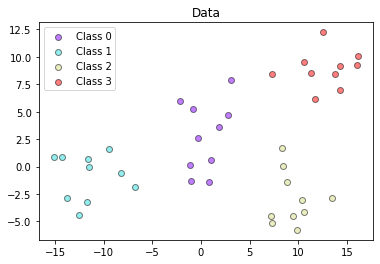

In [6]:
centers = [[0, 3], [-12, -1], [10, -2], [13, 9]] 
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 40, 
                            centers = centers, 
                            cluster_std = 2.2)
y_unique = np.unique(labels_true)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[labels_true == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

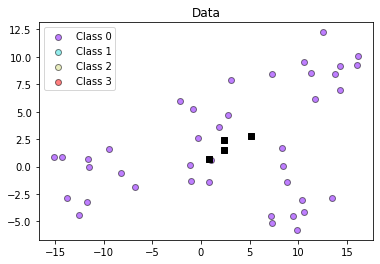

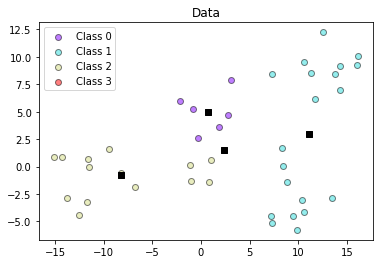

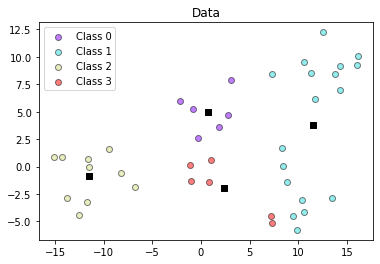

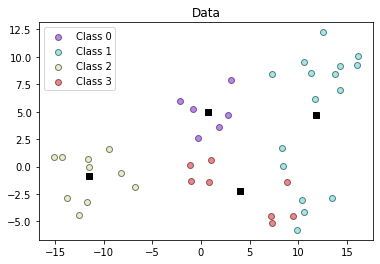

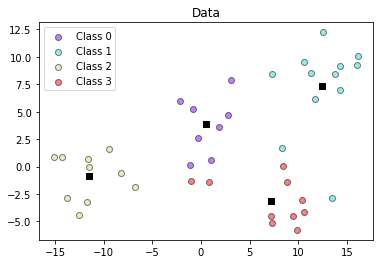

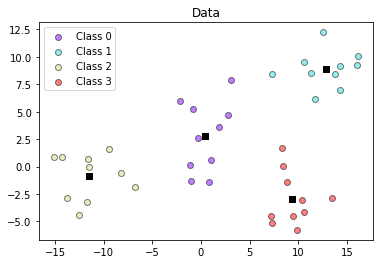

0.821898202416085

In [7]:
km = MyKmeans(X, 4, 'Random', 'euclidean', 5)
km.train()
centroids = km.give_centroids()
labels = km.give_labels()
silhouette(X, labels, centroids)

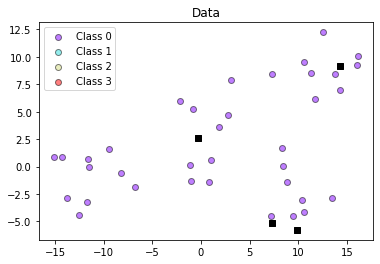

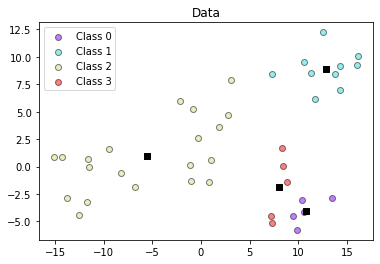

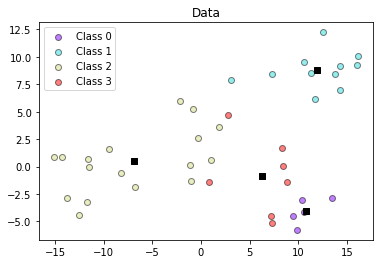

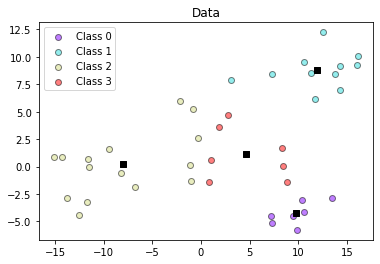

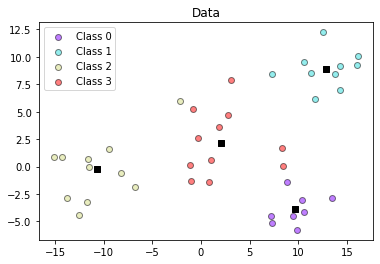

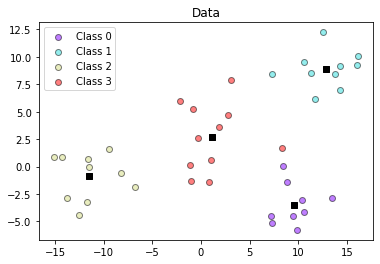

In [8]:
km = MyKmeans(X, 4, 'Forgy', 'euclidean', 5)
km.train()

### Interesting Observation
1. It might happen that no point gets assigned to a centroid, in that case we will not change it position.
2. In the upcoming iterations some points can be assigned to it as we see in the 2nd and 3rd graph below.

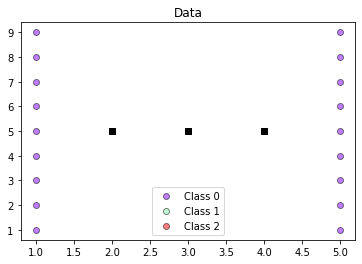

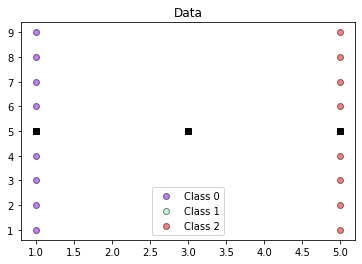

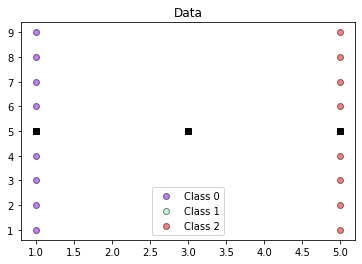

silhouette score : 0.5120134439604426


In [9]:
X = [[1, i] for i in range(1, 10)] + [[5, i] for i in range(1, 10)]
X = np.array(X)
centro = np.array([[2, 5], [3, 5], [4, 5]])
km = MyKmeans(X, 3, 'Random', 'euclidean', 2, centro=centro)
km.train()
centroids = km.give_centroids()
labels = km.give_labels()
print('silhouette score : {a}'.format(a=silhouette(X, labels, centroids)))

In [13]:
#implement Kmeans++ from scratch
class Kmeansplusplus:

    def __init__(self, X, k, dist_measure, iterations):
        self.dist_measure = dist_measure
        self.iterations = iterations
        self.k = k
        self.X = X
        self.centroids = np.zeros((k, X.shape[1]))
        self.labels = np.zeros(X.shape[0])
        self.dist = np.array([1e9]*X.shape[0])
    
    @staticmethod
    def choice(p):
        '''
        Generates a random sample from [0, len(p)),where p[i] is the probability associated with i. 
        '''
        random = np.random.random()
        cdf = 0.0
        for idx in range(p.shape[0]):
            cdf = cdf + p[idx]
            if cdf > random:
                return idx
        raise ValueError("probabilities don't add up to 1.0")
        
    def update(self, centroids):
        dist_mat = -2*np.dot(centroids, self.X.T) + np.sum(self.X**2, axis=1) + np.sum(centroids**2, axis=1)[:, np.newaxis]
        dist_mat = np.min(dist_mat, axis=0)
        self.dist = np.min([dist_mat, self.dist], axis=0) # take the point-wise min and update the dist array
    
    def initialise(self):
        ind = np.random.randint(0, self.X.shape[0]) # get the first centroid
        self.centroids[0] = self.X[ind]
        for i in range(1, self.k):
            self.update(self.centroids[:i]) # update the distances
            probability = self.dist/self.dist.sum()
            ind = self.choice(probability)
            self.centroids[i] = self.X[ind]
        self.plot_data()
            
    def give_centroids(self):
        return self.centroids
    
    def give_labels(self):
        return self.labels
    
    def dist_matrix_manhattan(self):
        num_train = self.X.shape[0]
        dist_mat = np.zeros((num_train, self.k))
        for i in range(num_train):
            dist_mat[i, :] = np.sum(np.abs(self.centroids - self.X[i, :]), axis=1)
        return dist_mat
        
    def dist_matrix(self, X):
        dist_mat = -2*np.dot(self.X, X.T) + np.sum(X**2, axis=1) + np.sum(self.X**2, axis=1)[:, np.newaxis]
        return dist_mat
    
    def realign(self):
        if self.dist_measure == 'euclidean':
            dist_mat = self.dist_matrix_manhattan()
        elif self.dist_measure == 'manhattan':
            dist_mat = self.dist_matrix(self.centroids)
        else:
            raise NotImplementedError('Wrong distance measure')
        clusters = np.argmin(dist_mat, axis=1)
        for i in range(self.k):
            mask = clusters == i
            x_new = self.X[mask]
            if x_new.shape[0] > 0: # It might happen that no point is assigned to a particular centroid (Quite Dangerous)
                self.centroids[i] = x_new.mean(axis=0)
        self.labels = clusters
        self.plot_data()
        
    def plot_data(self):
        if self.X.shape[1] == 2:
            colors = cm.rainbow(np.linspace(0.0, 1.0, self.k))
            for this_y, color in zip(range(self.k), colors):
                this_X = self.X[self.labels == this_y]
                plt.scatter(this_X[:, 0], this_X[:, 1],
                            c=color[np.newaxis, :],
                            alpha=0.5, edgecolor='k',
                            label="Class %s" % this_y)
            plt.legend(loc="best")
            plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker="s", c='black')
            plt.title("Data")
            plt.show()
    
    def train(self):
        self.initialise()
        for _ in range(self.iterations):
            self.realign()
 

In [14]:
def give_cent(X, cent):
    dist_mat = -2*np.dot(X, cent.T) + np.sum(cent**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    assigned_cent = np.argmin(dist_mat, axis=1)
    return assigned_cent

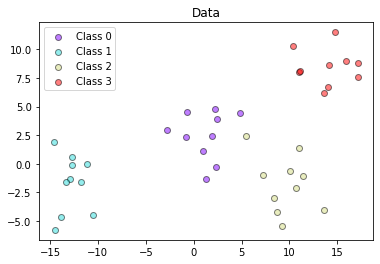

In [11]:
centers = [[0, 3], [-12, -1], [10, -2], [13, 9]] 
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 40, 
                            centers = centers, 
                            cluster_std = 2.2)
y_unique = np.unique(labels_true)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[labels_true == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

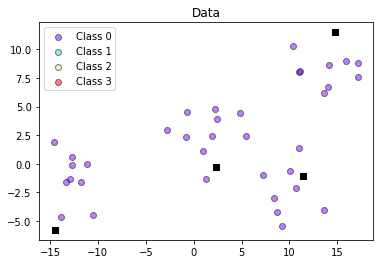

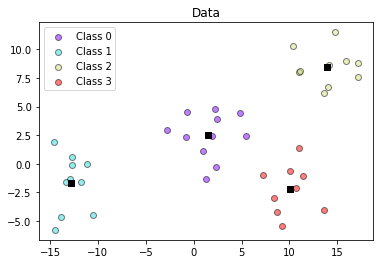

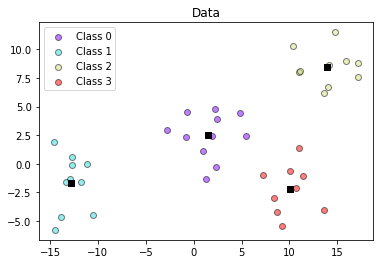

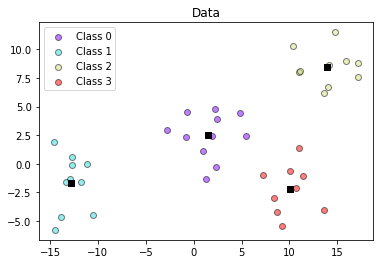

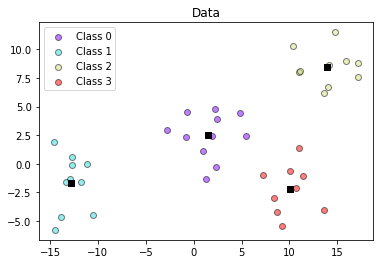

In [16]:
km = Kmeansplusplus(X, 4, 'euclidean', 4)
km.train()

### Actual Dataset

In [42]:
train = pd.read_csv('./drive/MyDrive/fashion-mnist_train.csv')
test = pd.read_csv('./drive/MyDrive/fashion-mnist_test.csv')
y_train = train['label']
y_test = test['label']
x_train = train.drop(['label'], axis=1)
x_test = test.drop(['label'], axis=1)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## K Means ++

### Without normalisation and subsampling
#### Since MY Laptop cannot handle this much data and it heats up pretty quickly I have subsampled the data

In [43]:
x_train = x_train[:4000]
y_train = y_train[:4000]
x_test = x_test[:2000]
y_test = y_test[:2000]
K_MAX = 15
K_LOW = 5

In [65]:
def print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.plot(range(K_LOW, K_MAX), sil_score, '-bx')
    plt.title('Silhouette Score Vs K (TRAIN)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.subplot(2, 3, 2)
    plt.plot(range(K_LOW, K_MAX), elbow_score, '-bx')
    plt.title('Elbow score Vs K (TRAIN)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.subplot(2, 3, 3)
    plt.plot(range(K_LOW, K_MAX), homo_score, '-bx')
    plt.title('Homogeneity score Vs K (TRAIN)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.subplot(2, 3, 4)
    plt.plot(range(K_LOW, K_MAX), sil_score_test, '-bx')
    plt.title('Silhouette Score Vs K (TEST)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.subplot(2, 3, 5)
    plt.plot(range(K_LOW, K_MAX), elbow_score_test, '-bx')
    plt.title('Elbow score Vs K (TEST)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.subplot(2, 3, 6)
    plt.plot(range(K_LOW, K_MAX), homo_score_test, '-bx')
    plt.title('Homogeneity score Vs K (TEST)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.show()

#### Graph plotting

In [44]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []

for k in range(K_LOW, K_MAX):
    km = Kmeansplusplus(x_train, k, 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))

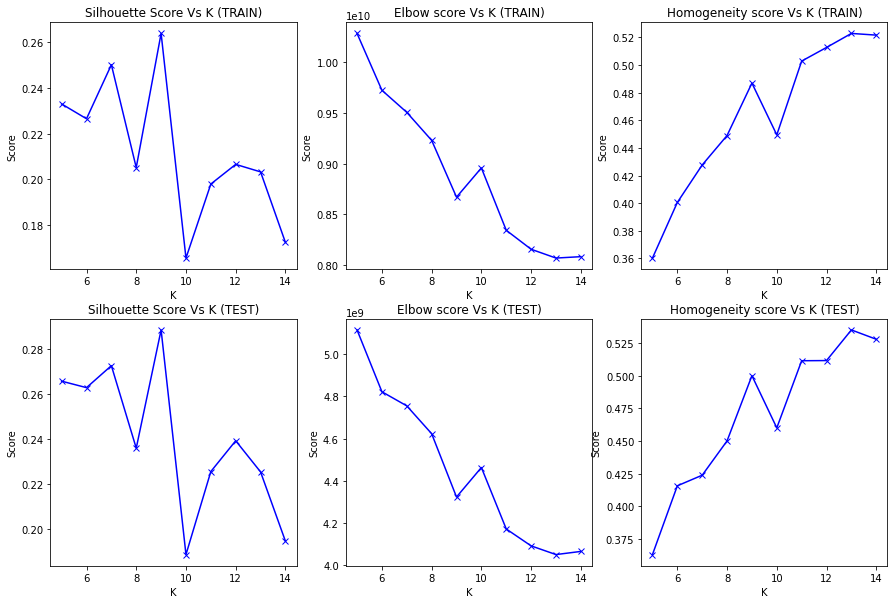

In [46]:
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

According to above plots best value of $K$ is $9$

### With normalization and Subsampling

In [47]:
x_train = x_train/255.0

In [48]:
x_test = x_test/255.0

#### Graph plotting

In [51]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = Kmeansplusplus(x_train, k, 'manhattan', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))

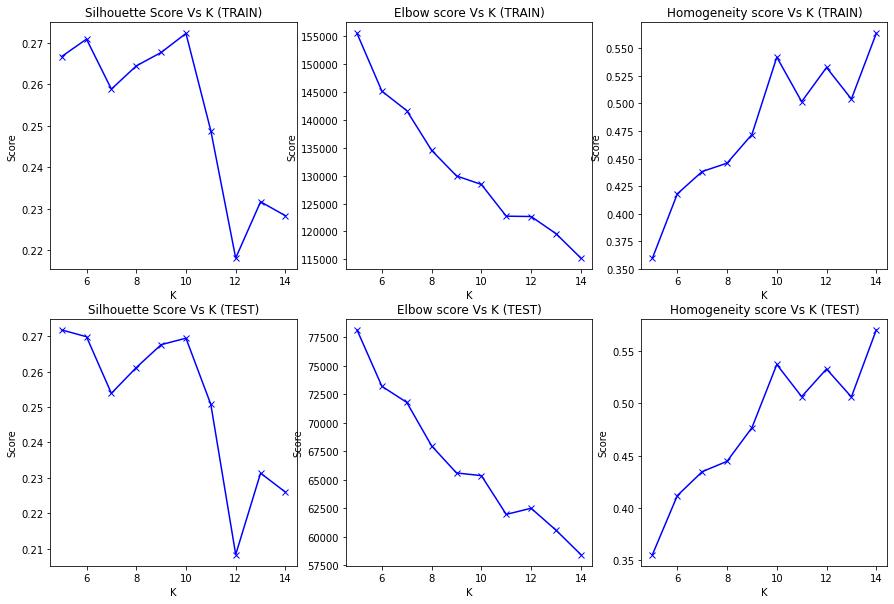

In [52]:
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

#### Observations
- The graph of elbow score show a steep decrease till value of $10$, after which there is not much decrease, which suggest that the optimal value of $K$ is $10$.
- The graph of silhouette score further strengthen our assumption of optimal $K$ value. As we can see that the score shoots up at the $K$ value 10.

#### Effect of Normalisation
- After doing normalisation the correct optimal value of $K$ is predicted by silhouette score. As we can see that silhouetter score shoots up in normalised data as compared with un-normalised one.
- Also nomalisation eliminates the bias of any feature which has large values.

### T-SNE

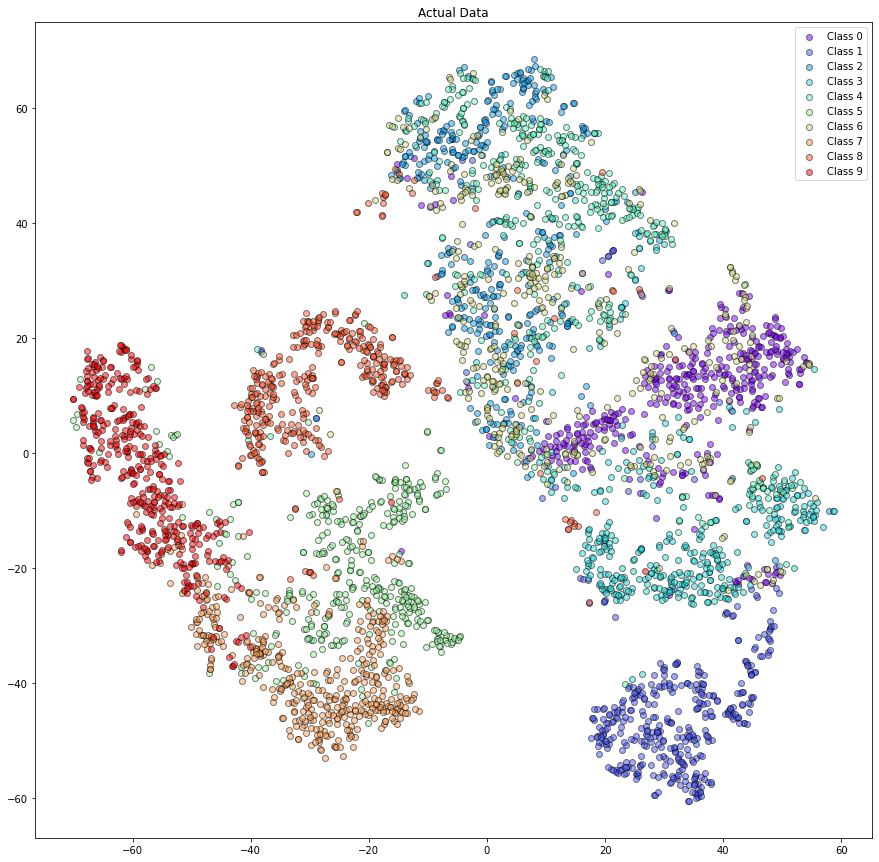

In [60]:
X = TSNE(n_components=2).fit_transform(x_train)
colors = cm.rainbow(np.linspace(0.0, 1.0, 10))
plt.figure(figsize=(15, 15))
for this_y, color in zip(range(10), colors):
    this_X = X[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Actual Data")
plt.show()

In [ ]:
cluster = 10
km = Kmeansplusplus(x_train, cluster, 'manhattan', 90) # Since the optimal value is 8
km.train()
labels = km.give_labels()
X = TSNE(n_components=2).fit_transform(x_train)
colors = cm.rainbow(np.linspace(0.0, 1.0, cluster))

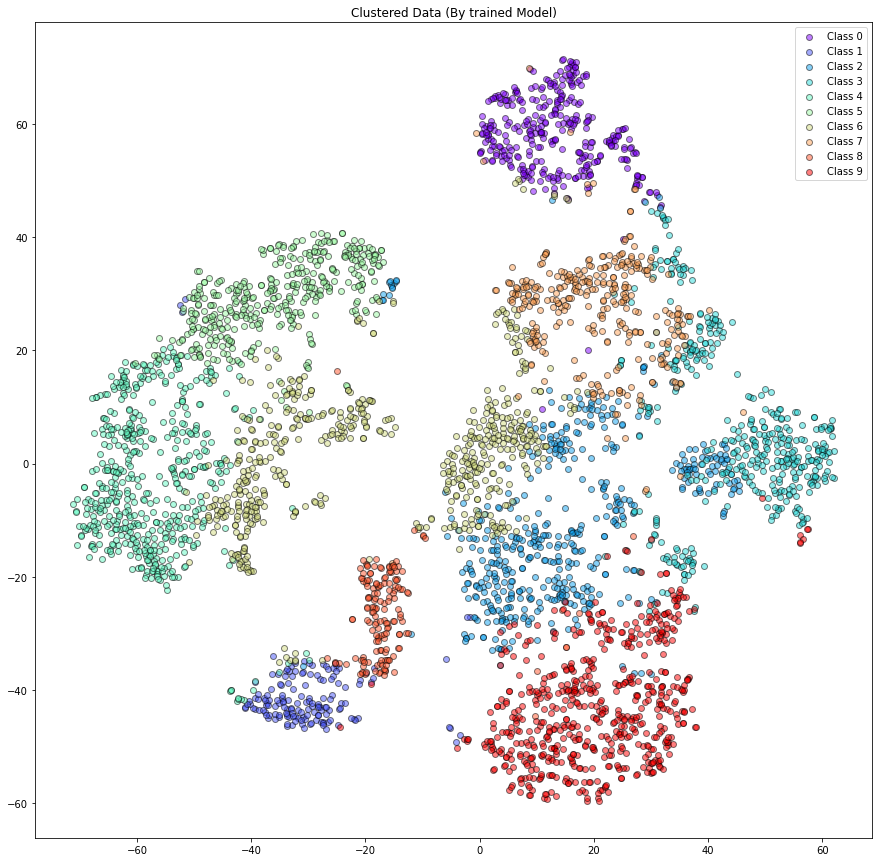

In [59]:
plt.figure(figsize=(15, 15))
for this_y, color in zip(range(cluster), colors):
    this_X = X[labels == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Clustered Data (By trained Model)")
plt.show()

### Comparison with Sklearn

In [61]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = KMeans(n_clusters=k)
    km.fit(x_train)
    labels = km.labels_
    centroids = km.cluster_centers_
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))

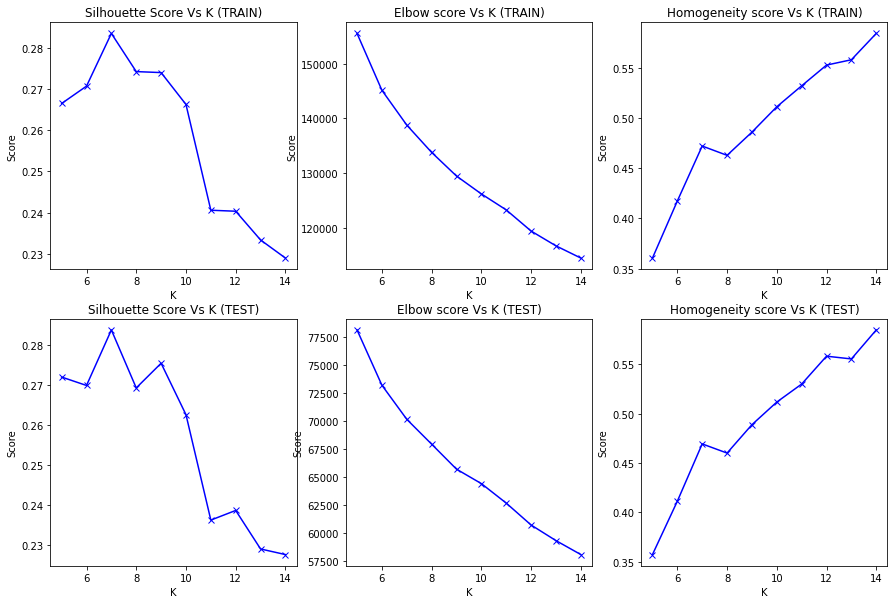

In [62]:
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

In the above plots we are not able to decide the optimal value of $K$, it can be anyone of $9$ or $10$.

## K-Means
#### Random initialisation method

In [63]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = MyKmeans(x_train, k,'Random', 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))

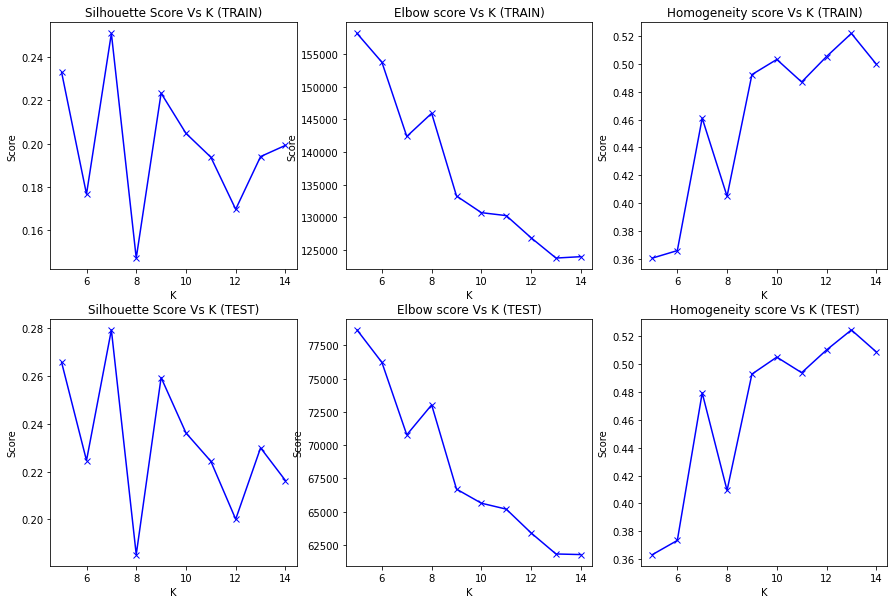

In [64]:
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

A **Clear Elbow** is visible at $K = 10$, hence the optimal value of $K$ is 10 in the above plots  

#### Forgy initialisation method

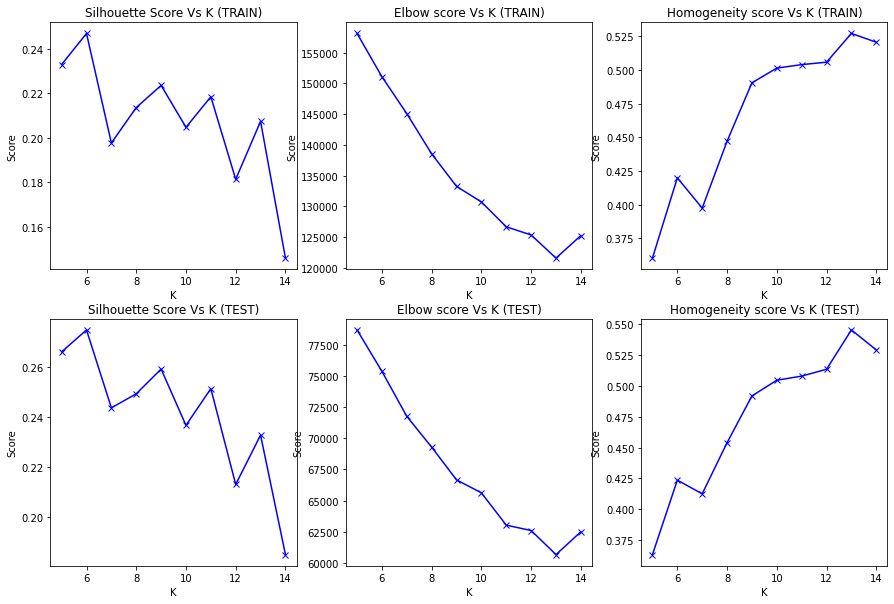

In [66]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = MyKmeans(x_train, k,'Forgy', 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))
    
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

Since the **Silhouette score** and a feeble *Elbow* is present at $K=9$, hence we can say that optimal value of $K$ is 9

#### Manhattan Distance

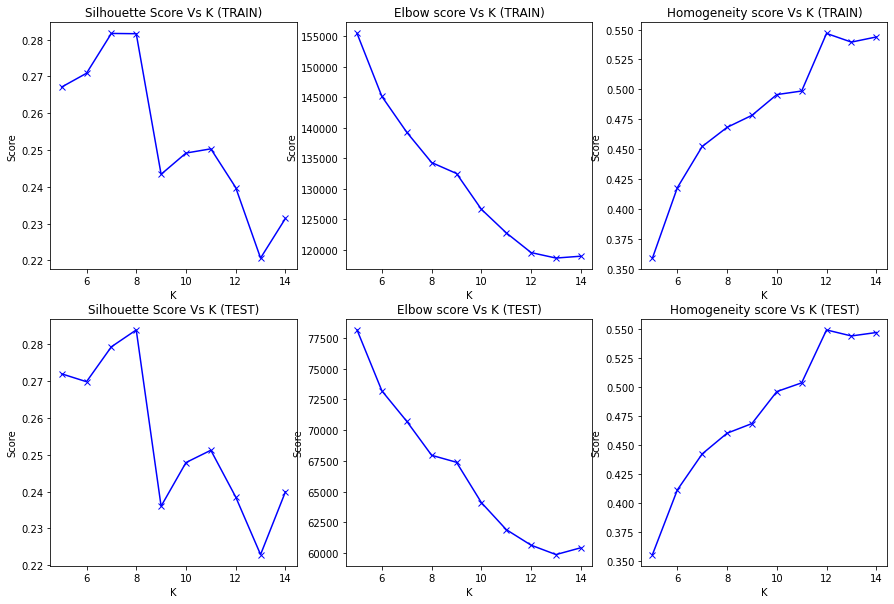

In [68]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = MyKmeans(x_train, k,'Random', 'manhattan', 80)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))
    
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

In the above plot we can see a **Clear Elbow** at $K=8$, hence optimal $K$ is $8$.

### Data Visualisation

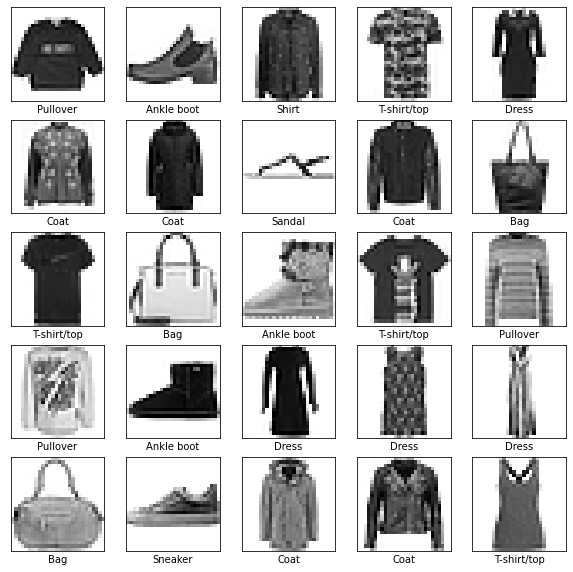

In [70]:
x_train = x_train.reshape(4000, 28, 28)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Latent Representation

In [71]:
class_names = [' T-Shirt', ' Trouser', ' Pullover', ' Dress', ' Coat', ' Sandal', ' Shirt', ' Sneaker', ' Bag', ' Ankle Boot']
mapping = dict()
for i in range(len(class_names)):
    mapping[class_names[i]] = i
mapping['Top'] = 0

In [77]:
df = pd.read_csv('./drive/MyDrive/data.csv', header=None)
df.replace(to_replace=mapping, inplace=True) # replace the class_names with numeric values
Y = df[192].to_numpy()
Y = np.array(Y)
df.drop(columns=192, inplace=True)
def correct(x):
    return x[1:]
df[0] = df[0].apply(correct)
def back_correct(x):
    return x[:-1]
df[191] = df[191].apply(back_correct)
df = df.astype(np.float64)
X = df.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, shuffle=True)
x_train = x_train[:4000]
y_train = y_train[:4000]
x_test = x_test[:2000]
y_test = y_test[:2000]

### K Means ++

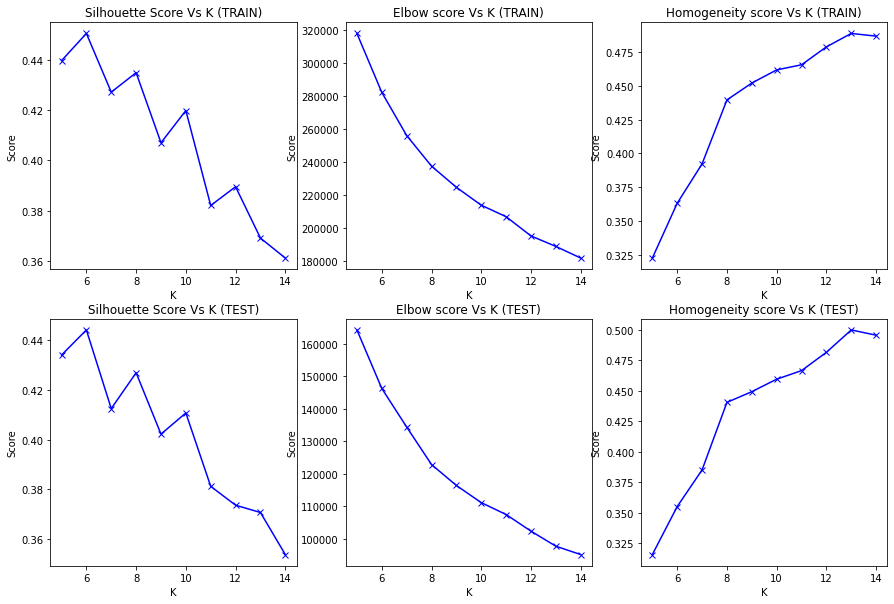

In [78]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = Kmeansplusplus(x_train, k, 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))
    
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

Since a good **Silhouette score** and a *Elbow* is present at $K=10$, hence we can say that optimal value of $K$ is $10$.

### K Means
#### Random Initialisation

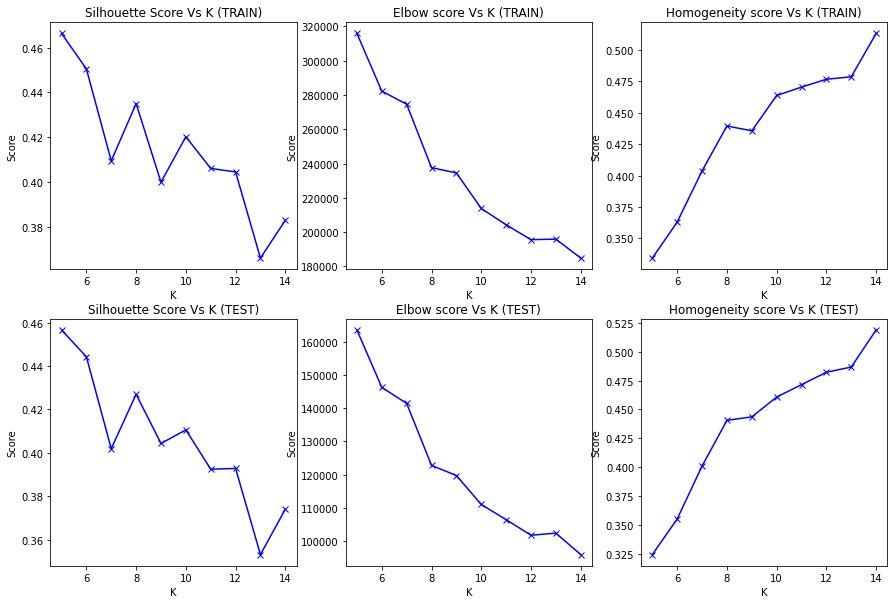

In [81]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = MyKmeans(x_train, k,'Random', 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))
    
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

$K$ can be $8$ or $10$

#### Forgy Initialisation

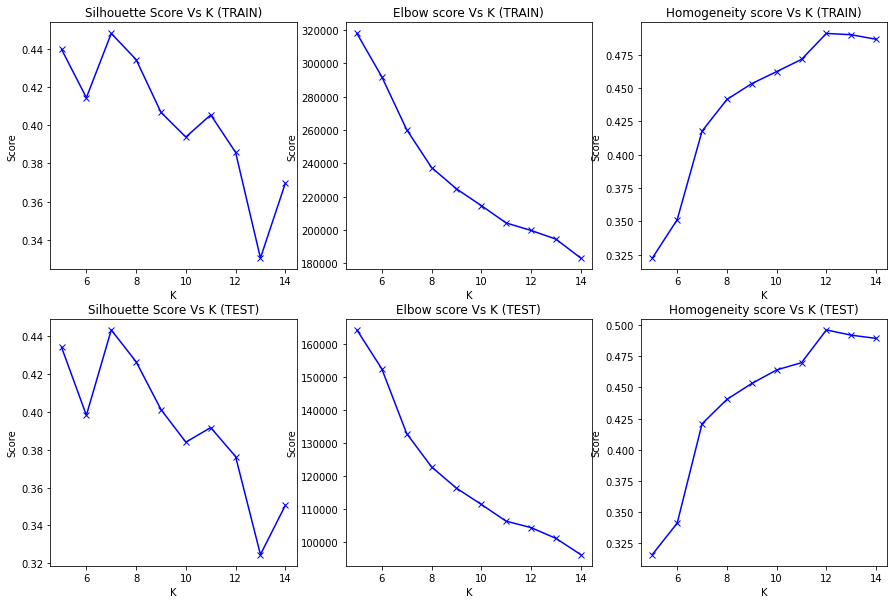

In [82]:
sil_score, sil_score_test = [], []
elbow_score, elbow_score_test = [], []
homo_score, homo_score_test = [], []
for k in range(K_LOW, K_MAX):
    km = MyKmeans(x_train, k,'Forgy', 'euclidean', 90)
    km.train()
    centroids = km.give_centroids()
    labels = km.give_labels()
    correct_label = np.zeros(k)
    sil_score.append(silhouette(x_train, labels, centroids))
    elbow_score.append(elbow(x_train, labels, centroids))
    homo_score.append(homogeneity_score(y_train, labels))
    assigned_cents = give_cent(x_test, centroids)
    sil_score_test.append(silhouette(x_test, assigned_cents, centroids))
    elbow_score_test.append(elbow(x_test, assigned_cents, centroids))
    homo_score_test.append(homogeneity_score(y_test, assigned_cents))
    
print_graphs(sil_score, sil_score_test, elbow_score, elbow_score_test, homo_score, homo_score_test)

Since there is a feeble **Elbow**, we decide using the Silhouette score, and score is higher for $K=8$, hence we optimal value of $K$ is 8.

### Comparison of Latent representation and normal representation
- The time taken is much less as compared to the normal representation since the number of features have been reduced significantly
- The silhouette scores have improved from ~(0.25-0.30) to ~(0.35-0.40).
- This means that the latent representation extracts those features which are important for clustering with similar data points and also reduces the dimensionality.